<!--Header-->
<div style="background-color: #fff; color: black">
    <div style="padding-bottom: 20px; display: flex; justify-content: space-between; align-items: flex-start;">
        <div style="width: 60%;">
            <h1 style="margin: 16px">TFG - Inteligencia Artificial</h1>
            <p style="margin: 16px; padding-bottom: 0">Junio de 2025</p>
        </div>
        <div style="width: 40%; text-align: right">
            <img src="https://www.uoc.edu/portal/_resources/common/imatges/marca_UOC/UOC_Masterbrand.jpg" alt="Logo UOC">
        </div>
    </div>
    <h2 style="text-align: justify; padding: 0 16px">Aplicación de técnicas de IA fiable en la predicción del índice de calidad de vida en personas con tratamiento oncológico mediante aprendizaje automático.</h2>
    <div style="background-color: #000; width: 100%; height: 2px; margin: 24px 0"></div>
    <div style="padding: 20px">
        <h4 style="margin: 0 0; padding: 0 0">Pablo Pimàs Verge</h4>
        <h5 style="margin: 0 0; padding: 0 0">Grado en Ingeniería Informática</h5>
        <h5 style="margin: 0 0 4px; padding: 0 0">Inteligencia Artificial</h5>
        <h4 style="margin: 8px 0 4px; padding: 0 0">Dra. María Moreno de Castro</h4>
        <h4 style="margin: 0 0; padding: 0 0">Dr. Friman Sanchéz</h4>
    </div>
</div>

<!--/Header-->

# Fase 2
#### Segunda Parte
##### - Entrenamiento de modelos
##### - Aplicación del modelo óptimo

# Modelado

El problema planteado es una clasificación multiclase del índice de calidad de vida (QoL) en personas con tratamiento oncológico. En la primera parte se ha realizado el análisis exploratorio de datos y la preparación [1]. En el análisis se han identificado dos tipos de predictores: las variables que informan aspectos de funcionamiento e inciden positivamente en el QoL; y las variables que informan síntomas, producidos por la enfermedad o el tratamiento, e inciden negativamente en el QoL. Por razones prácticas, nombraremos a estos dos tipos variables directas y variables inversas respectivamente. Con respecto a la preparación, se ha reducido la variable calidad de vida QoL a 3 clases para mejorar la clasificación y dotarla de sentido semántico, estas son: 0 (baja), 1 (media) y 2 (alta). Además, del conjunto inicial con 1727 observaciones, se han eliminado 249 filas con valores nulos en todas las columnas y 4 filas con valores nulos en las variables del dominio C23. Por último, también se han eliminado las variables Upset by hair loss y Sexual enjoyment por contener más de un 60% de valores nulos. Por lo tanto, el conjunto resultante contiene 1474 observaciones compuestas por 20 predictores y la variable objetivo.

Este cuaderno corresponde a la segunda parte de la fase 2 del plan de trabajo del TFG. Se aborda el entrenamiento y la aplicación de los modelos previstos al conjunto de datos resultante de la preparación. Estas tareas corresponden a la fase de modelado en el marco de CRISP-DM.


### Objetivos

En el presente cuaderno se realizarán las siguientes acciones: 

- Separar los datos de df_C30_C23 en los conjuntos de: entrenamiento, prueba, validación y calibración
- Entrenar y aplicar los siguientes modelos:

### Índice

1. Entrenamiento y clasificación
    - modelo 1
    - modelo 2
    - modelo 3 
    - modelo 4
2. Selección del modelo óptimo

### Importaciones

In [1]:
# Importaciones de librerías básicas
import joblib
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import warnings

# Importaciones de Scikit-learn para preparación de datos, evaluación de modelos y optimización de parámetros
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import classification_report

# Importaciones de Modelos
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from catboost import CatBoostClassifier
from lightgbm import LGBMClassifier

# Funciones auxiliares
import aux_functions as afn

In [2]:
# Configuraciones
%matplotlib inline
warnings.filterwarnings("ignore")
pd.options.display.float_format = '{:.2f}'.format
plt.rc('font', size=10)
plt.rcParams["legend.frameon"] = False
sns.set_theme(
    style="white",
    palette="viridis",
    rc={
        "axes.spines.left": False,
        "axes.spines.bottom": False,
        "axes.spines.right": False,
        "axes.spines.top": False
    }
)
sns.set_style("white", {"axes.grid": False})

### Carga de los datos

In [3]:
# Carga de los datos en un dataframe de Pandas a partir del conjunto generado en la fase previa en formato csv
file_path = "./data/QLQ_C30_C23_2.csv"
df = pd.read_csv(file_path)
# Filas duplicadas
print('Total de observaciones sin duplicados: ', df.duplicated().count())

Total de observaciones sin duplicados:  1474


In [4]:
# Comprobamos que el conjunto importado contiene las 1474 observaciones sin valores faltantes y las 21 variables de tipo decimal (float)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1474 entries, 0 to 1473
Data columns (total 21 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   Physical functioning           1474 non-null   float64
 1   Role functioning               1474 non-null   float64
 2   Emotional functioning          1474 non-null   float64
 3   Cognitive functioning          1474 non-null   float64
 4   Social functioning             1474 non-null   float64
 5   Fatigue                        1474 non-null   float64
 6   Nausea and vomiting            1474 non-null   float64
 7   Pain                           1474 non-null   float64
 8   Dyspnea                        1474 non-null   float64
 9   Insomnia                       1474 non-null   float64
 10  Appetite loss                  1474 non-null   float64
 11  Constipation                   1474 non-null   float64
 12  Diarrhea                       1474 non-null   f

## 1. Creación de los conjuntos de entrenamiento, prueba y calibración

Para la división de los conjuntos de entrenamiento y prueba aplicaremos una proporción de 70-30 con estratificación para asegurar que las clases de la variable objetivo se distribuyan uniformemente en todos los conjuntos. 
Con el fin de cuantificar la incertidumbre del modelo en la próxima etapa, es necesario reservar un subconjunto de los datos, que se utilizarán para realizar la calibración. Para ello, separamos un 20% del conjunto de prueba, ya que el modelo no debe conocerlos durante el entrenamiento.


In [5]:
# Extracción de las variables independientes en un dataframe y de la variable dependiente en una serie
X = df.drop('QoL', axis=1)
y = df['QoL']
# Apartamos el 10% de los datos para probar el modelo definitivo 
X_temp, X_test, y_temp, y_test = train_test_split(X, y, test_size=0.10, stratify=y, random_state=73)
# Del 90% restante, separamos 15% para calibración, 15% para validación y el 70% restante para el entrenamiento
X_train, X_rest, y_train, y_rest = train_test_split(X_temp, y_temp, test_size=0.30, stratify=y_temp, random_state=73)
X_cal, X_val, y_cal, y_val = train_test_split(X_rest, y_rest, test_size=0.50, stratify=y_rest, random_state=73)


Una vez dispuestos todos los conjuntos necesarios, mediante la función auxiliar viz_split_distributions realizaremos una comprobación de la distribución de las 3 clases en cada uno de ellos. 

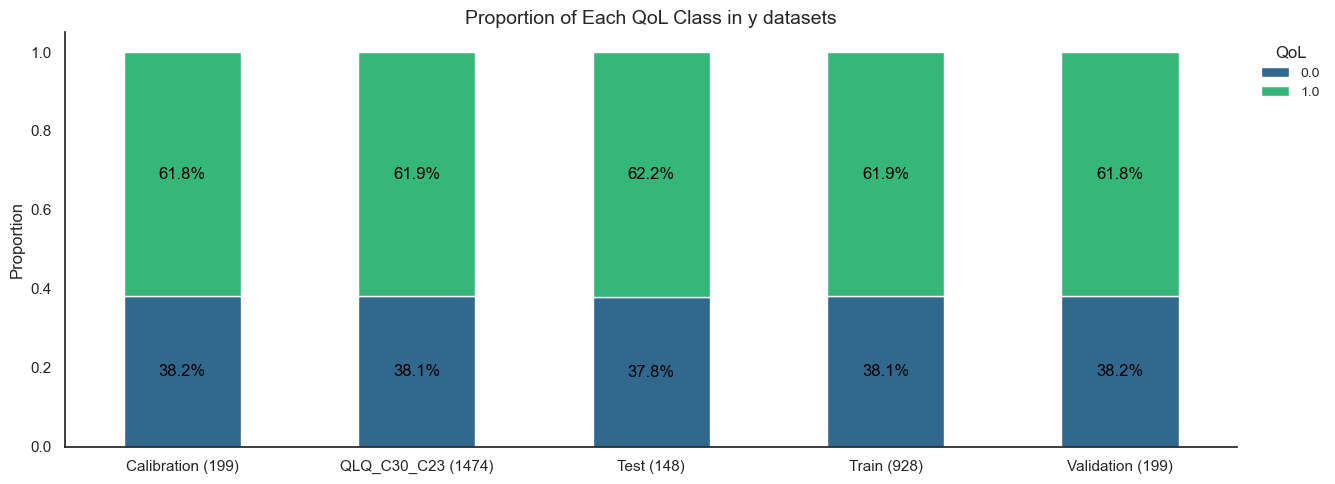

In [6]:
afn.viz_split_distributions([df['QoL'], y_train, y_val, y_test, y_cal], ['QLQ_C30_C23', 'Train', 'Validation', 'Test', 'Calibration'])

Podemos ver que la distribución de la variable objetivo tiene una variación inferior al 1% para cada clase en todos los conjuntos generados. Además, las 1474 observaciones del conjunto original se han separado en: 928 para entrenamiento, 199 para la validación, 148 para el test y 199 para la calibración.

In [7]:
# Guardamos los conjuntos en una lista para ser usada en las funciones auxiliares
datasets = [X_train, y_train]
labels = ['Aceptable', 'Mejorable']

## 2. Entrenamiento

Para la clasificación se entrenarán los siguientes modelos:

- Decision Tree 
- Random Forest
- XGBoost
- CatBoost
- LightGBM

### 2.1 Decision Tree

In [8]:
# Instanciamos el modelo 
decision_tree =  DecisionTreeClassifier(random_state=73)
# Establecemos un diccionario con los valores de los parámetros que tomará el modelo en el entrenamiento
dt_parameters = {
    # Criterios para medir la ganancia de información (calidad de la división)
    'criterion': ['gini', 'entropy'],
    # Estrategias de división
    'splitter': ['best', 'random'],
    # Máxima profundidades del árbol (None permite la profundidad máxima posible)
    'max_depth': [8, 9, 10],
    # Mínimo de casos para dividir un nodo
    'min_samples_split': [3, 5, 7],
    # Mínimo de casos en las hojas
    'min_samples_leaf': [8, 9, 10],
    # Factor de poda
    'ccp_alpha': [0.003, 0.004, 0.005]
}

# Creamos la grilla de búsqueda de parámetros
dt_grid = GridSearchCV(
    estimator=decision_tree, 
    param_grid=dt_parameters, 
    verbose=1,
    scoring='f1_macro',
    cv=5,
    n_jobs=-1
)

# Entrenamos los modelos generados por la grilla
%time dt_grid.fit(X_train, y_train)

# Visualización de los resultados
print('Media de F1 score: %.3f' % dt_grid.best_score_)
print('Desviación estándar: ', dt_grid.cv_results_['std_test_score'][dt_grid.best_index_].round(3))
print('Parámetros que producen el mejor clasificador: ')
print('Criterio: ', dt_grid.best_params_['criterion'])
print('Estrategia: ', dt_grid.best_params_['splitter'])
print('Profundidad máxima: ', dt_grid.best_params_['max_depth'])
print('Mínimo de muestras por división: ', dt_grid.best_params_['min_samples_split'])
print('Mínimo de muestras por hoja: ', dt_grid.best_params_['min_samples_leaf'])
print('Factor de poda: ', dt_grid.best_params_['ccp_alpha'])
print('Cantidad de nodos: ', dt_grid.best_estimator_.tree_.node_count)
print('Cantidad de hojas: ', dt_grid.best_estimator_.tree_.n_leaves)

Fitting 5 folds for each of 324 candidates, totalling 1620 fits
CPU times: user 355 ms, sys: 103 ms, total: 458 ms
Wall time: 3.19 s
Media de F1 score: 0.744
Desviación estándar:  0.014
Parámetros que producen el mejor clasificador: 
Criterio:  entropy
Estrategia:  random
Profundidad máxima:  9
Mínimo de muestras por división:  3
Mínimo de muestras por hoja:  9
Factor de poda:  0.004
Cantidad de nodos:  47
Cantidad de hojas:  24


In [9]:
# Entrenamos el modelo con los mejores hiperparámetros
dt_model = dt_grid.best_estimator_
dt_model.fit(X_train, y_train)
y_pred_dt = dt_model.predict_proba(X_val)

Reporte sobre el conjunto de ENTRENAMIENTO:
              precision    recall  f1-score   support

         0.0       0.69      0.81      0.75       354
         1.0       0.87      0.78      0.82       574

    accuracy                           0.79       928
   macro avg       0.78      0.79      0.78       928
weighted avg       0.80      0.79      0.79       928

Reporte sobre el conjunto de validation:  VALIDATION
              precision    recall  f1-score   support

         0.0       0.62      0.66      0.64        76
         1.0       0.78      0.76      0.77       123

    accuracy                           0.72       199
   macro avg       0.70      0.71      0.70       199
weighted avg       0.72      0.72      0.72       199



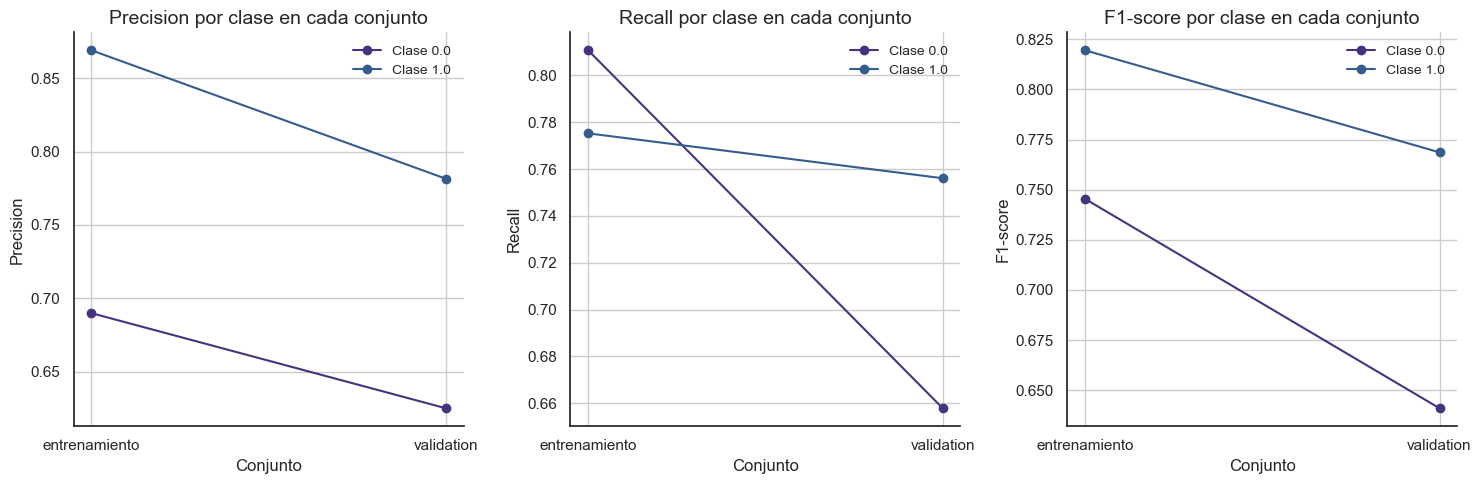

In [10]:
y_pred_train_dt, y_pred_val_dt = afn.viz_classification_reports(dt_model, X_train, y_train, X_val, y_val)

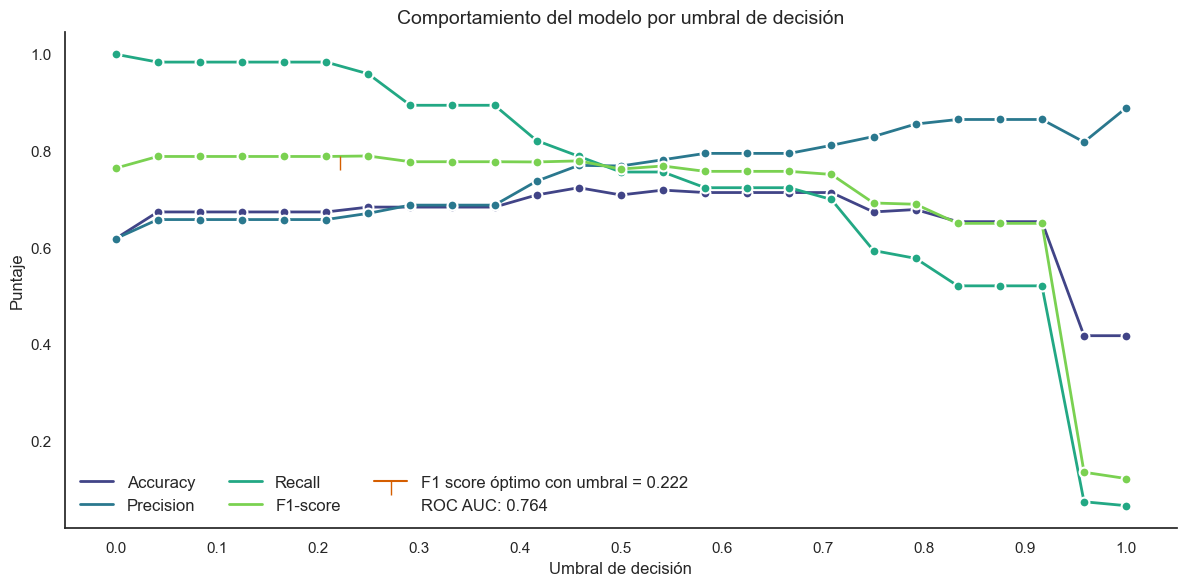

In [11]:
dt_best_threshold, dt_metrics = afn.viz_threshold_behavior(dt_model, X_val, y_val, num_thresholds=25)
dt_metrics['model'] = 'Decision Tree'


In [12]:
probs_dt = y_pred_dt[:, 1]
y_pred_proba_dt = (probs_dt >= dt_best_threshold)

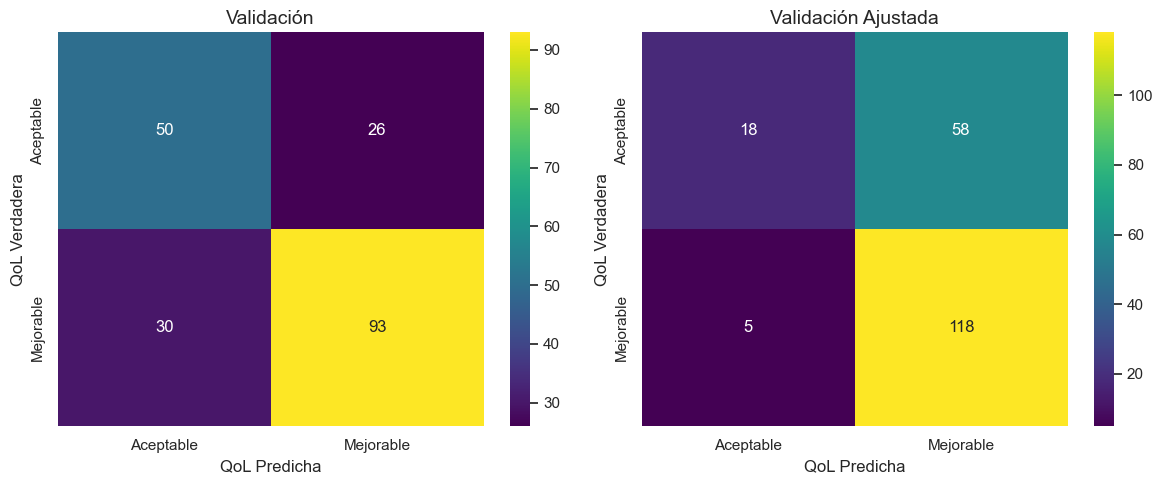

In [13]:
afn.viz_confusion_matrix_thres(labels, y_val, y_pred_val_dt, y_pred_proba_dt)

In [14]:
print("Reporte con umbral ajustado:")
print(classification_report(y_val, y_pred_proba_dt, target_names=labels))

Reporte con umbral ajustado:
              precision    recall  f1-score   support

   Aceptable       0.78      0.24      0.36        76
   Mejorable       0.67      0.96      0.79       123

    accuracy                           0.68       199
   macro avg       0.73      0.60      0.58       199
weighted avg       0.71      0.68      0.63       199



## 2.3 Random Forest

In [15]:
rf_model = RandomForestClassifier(
    random_state = 73,
    n_jobs=-1
)

rf_parameters = {
    'criterion': ['gini', 'entropy'],
    # Número de árboles en cada modelo
    'n_estimators': [90, 100, 120],
    'max_depth': [11, 12, 13],
    'min_samples_split': [3, 4, 5],
    'min_samples_leaf': [9, 10, 11],
    'ccp_alpha': [0.0065, 0.007, 0.0075]
}

rf_grid = GridSearchCV(
    estimator=rf_model,
    param_grid=rf_parameters,
    scoring='f1_micro',
    verbose=True,
    cv=5,
    n_jobs=-1
)

%time rf_grid.fit(X_train, y_train)

print('Media de recall: %.3f' % rf_grid.best_score_)
print('Desviación estándar: ', rf_grid.cv_results_['std_test_score'][rf_grid.best_index_].round(3))
print('Parámetros que producen el clasificador óptimo: ')
print('Criterio: ', rf_grid.best_params_['criterion'])
print('Profundidad máxima: ', rf_grid.best_params_['max_depth'])
print('Mínimo de muestras por división: ', rf_grid.best_params_['min_samples_split'])
print('Mínimo de muestras por hoja: ', rf_grid.best_params_['min_samples_leaf'])
print('Factor de poda: ', rf_grid.best_params_['ccp_alpha'])
print('Cantidad de árboles: ', rf_grid.best_params_['n_estimators'])
print('Cantidad de nodos del primer árbol: ', rf_grid.best_estimator_.estimators_[0].tree_.node_count)
print('Cantidad de hojas del primer árbol: ', rf_grid.best_estimator_.estimators_[0].tree_.n_leaves)

Fitting 5 folds for each of 486 candidates, totalling 2430 fits
CPU times: user 2.62 s, sys: 566 ms, total: 3.18 s
Wall time: 56.8 s
Media de recall: 0.775
Desviación estándar:  0.02
Parámetros que producen el clasificador óptimo: 
Criterio:  entropy
Profundidad máxima:  13
Mínimo de muestras por división:  3
Mínimo de muestras por hoja:  9
Factor de poda:  0.0065
Cantidad de árboles:  120
Cantidad de nodos del primer árbol:  23
Cantidad de hojas del primer árbol:  12


In [16]:
rf_model = rf_grid.best_estimator_
rf_model.fit(X_train, y_train)
y_pred_rf = rf_model.predict_proba(X_val)

Reporte sobre el conjunto de ENTRENAMIENTO:
              precision    recall  f1-score   support

         0.0       0.77      0.71      0.74       354
         1.0       0.83      0.87      0.85       574

    accuracy                           0.81       928
   macro avg       0.80      0.79      0.79       928
weighted avg       0.81      0.81      0.81       928

Reporte sobre el conjunto de validation:  VALIDATION
              precision    recall  f1-score   support

         0.0       0.70      0.66      0.68        76
         1.0       0.80      0.83      0.81       123

    accuracy                           0.76       199
   macro avg       0.75      0.74      0.75       199
weighted avg       0.76      0.76      0.76       199



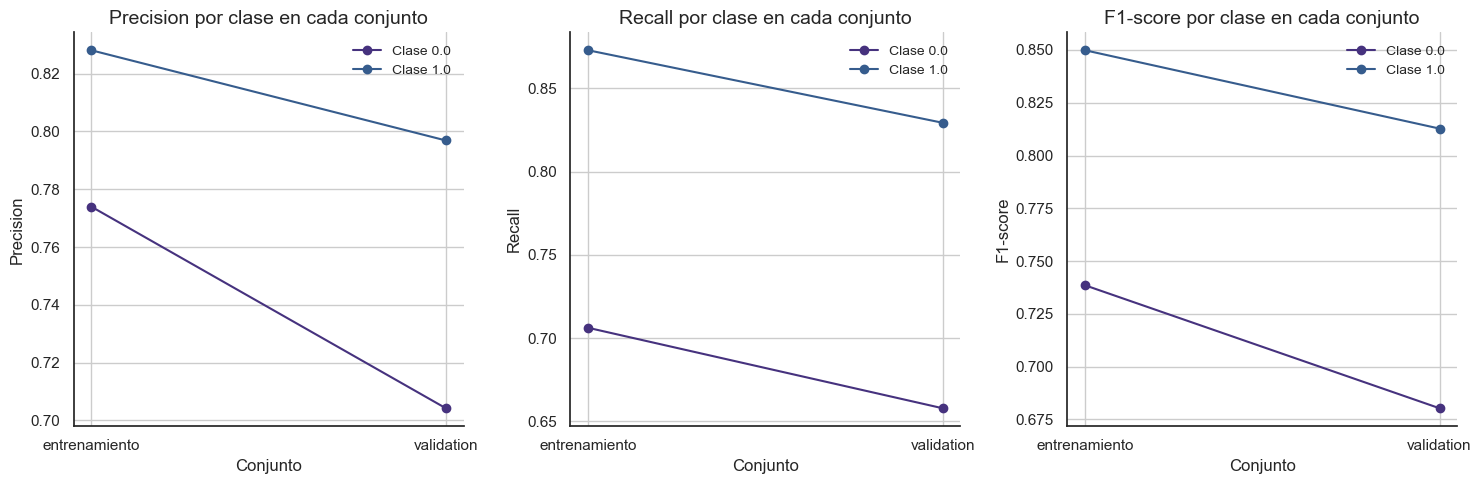

In [17]:
y_pred_train_rf, y_pred_val_rf = afn.viz_classification_reports(rf_model, X_train, y_train, X_val, y_val)

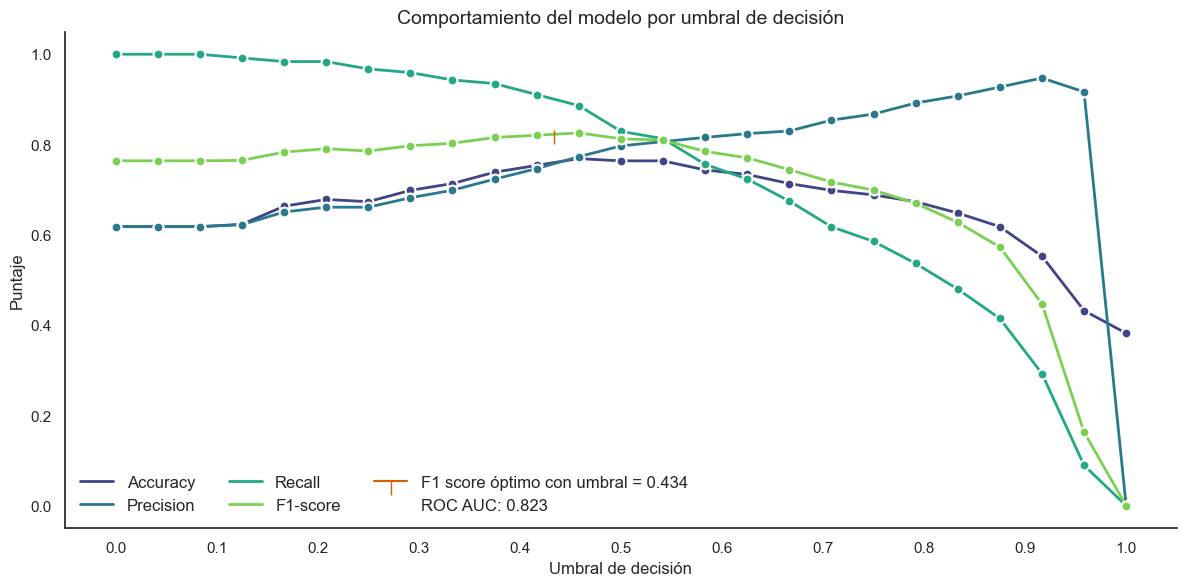

In [18]:
rf_best_threshold, rf_metrics = afn.viz_threshold_behavior(rf_model, X_val, y_val, num_thresholds=25)
rf_metrics['model'] = 'Random Forest'


In [19]:
probs_rf = y_pred_rf[:, 1]
y_pred_proba_rf = (probs_rf >= rf_best_threshold)

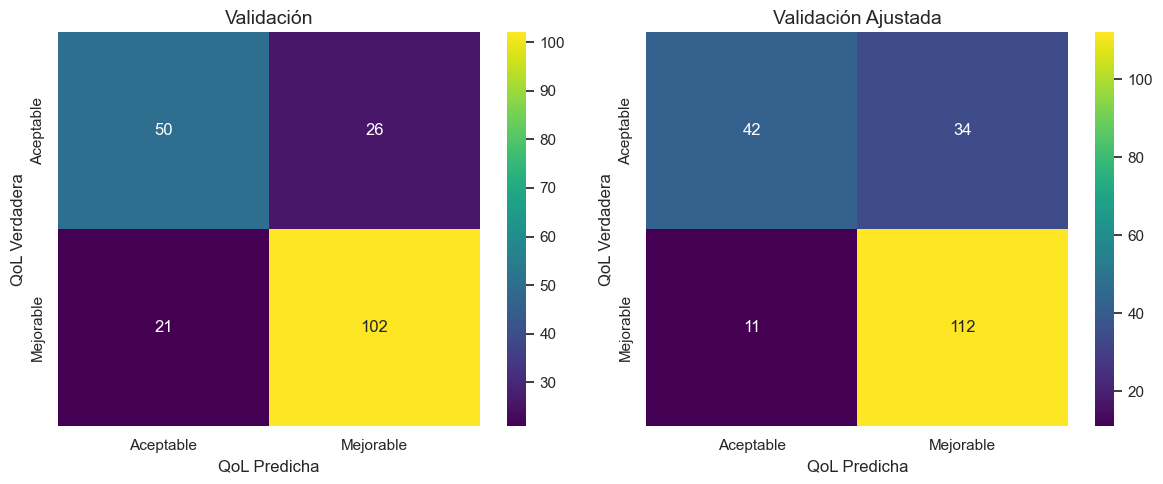

In [20]:
afn.viz_confusion_matrix_thres(labels, y_val, y_pred_val_rf, y_pred_proba_rf)

In [21]:

print("Reporte con umbral ajustado:")
print(classification_report(y_val, y_pred_proba_rf, target_names=labels))

Reporte con umbral ajustado:
              precision    recall  f1-score   support

   Aceptable       0.79      0.55      0.65        76
   Mejorable       0.77      0.91      0.83       123

    accuracy                           0.77       199
   macro avg       0.78      0.73      0.74       199
weighted avg       0.78      0.77      0.76       199



### 2.3 XGBoost

In [22]:
xg_parameters = {
    'eta': [0.05, 0.06, 0.07],
    'max_depth': [5, 6, 7],
    'min_child_weight': [3, 4, 7],
    'n_estimators': [70, 80, 90],
    'subsample': [0.9, 1.0, 1.1],
    'colsample_bytree': [0.8, 0.9, 1.0]
}

xg_model = XGBClassifier(
    objective='binary:logistic',               
    eval_metric='logloss',     
    random_state=73,
)

xg_grid = GridSearchCV(
    estimator=xg_model,
    param_grid=xg_parameters,
    scoring='f1_macro',
    cv=5,
    verbose=True,
    n_jobs=-1
)

%time xg_grid.fit(X_train, y_train)

print('Media de recall: %.3f' % xg_grid.best_score_)
print('Desviación estándar: ', xg_grid.cv_results_['std_test_score'][xg_grid.best_index_].round(3))
print('Parámetros que producen el clasificador óptimo: ')
print('Tasa de aprendizaje: ', xg_grid.best_params_['eta'])
print('Profundidad máxima: ', xg_grid.best_params_['max_depth'])
print('Mínimo peso de división: ', xg_grid.best_params_['min_child_weight'])
print('Número de árboles: ', xg_grid.best_params_['n_estimators'])
print('Subsample: ', xg_grid.best_params_['subsample'])
print('Colsample por árbol: ', xg_grid.best_params_['colsample_bytree'])

Fitting 5 folds for each of 729 candidates, totalling 3645 fits
CPU times: user 2.03 s, sys: 158 ms, total: 2.19 s
Wall time: 7.26 s
Media de recall: 0.773
Desviación estándar:  0.049
Parámetros que producen el clasificador óptimo: 
Tasa de aprendizaje:  0.06
Profundidad máxima:  6
Mínimo peso de división:  4
Número de árboles:  80
Subsample:  1.0
Colsample por árbol:  0.9


In [23]:
xg_model = xg_grid.best_estimator_
xg_model.fit(X_train, y_train)
y_pred_xg = xg_model.predict_proba(X_val)


Reporte sobre el conjunto de ENTRENAMIENTO:
              precision    recall  f1-score   support

         0.0       0.84      0.82      0.83       354
         1.0       0.89      0.90      0.90       574

    accuracy                           0.87       928
   macro avg       0.87      0.86      0.86       928
weighted avg       0.87      0.87      0.87       928

Reporte sobre el conjunto de validation:  VALIDATION
              precision    recall  f1-score   support

         0.0       0.69      0.70      0.69        76
         1.0       0.81      0.80      0.81       123

    accuracy                           0.76       199
   macro avg       0.75      0.75      0.75       199
weighted avg       0.76      0.76      0.76       199



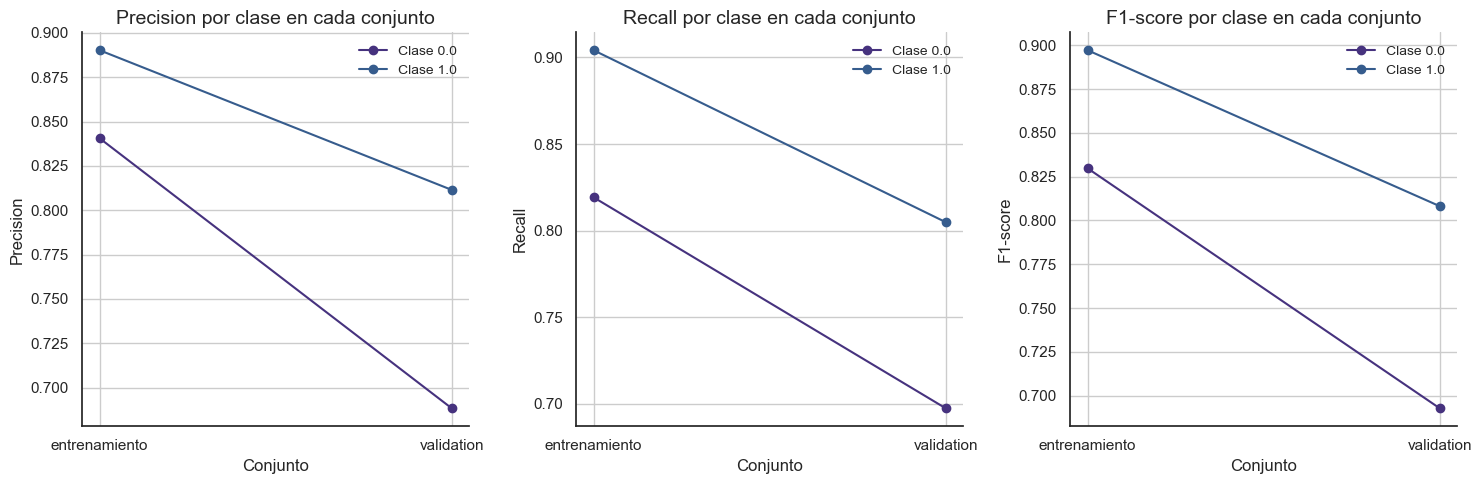

In [24]:
y_pred_train_xg, y_pred_val_xg = afn.viz_classification_reports(xg_model, X_train, y_train, X_val, y_val)

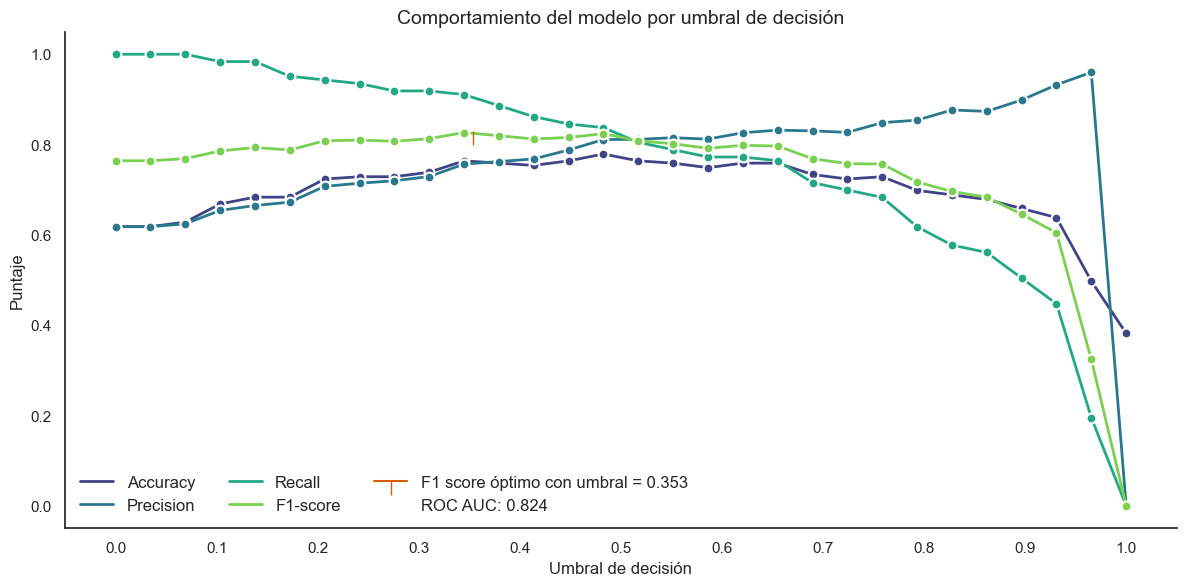

In [25]:
xg_best_threshold, xg_metrics = afn.viz_threshold_behavior(xg_model, X_val, y_val, num_thresholds=30)
xg_metrics['model'] = 'XGBoost'

In [26]:
probs_xg = y_pred_xg[:, 1]
y_pred_proba_xg = (probs_xg >= xg_best_threshold)

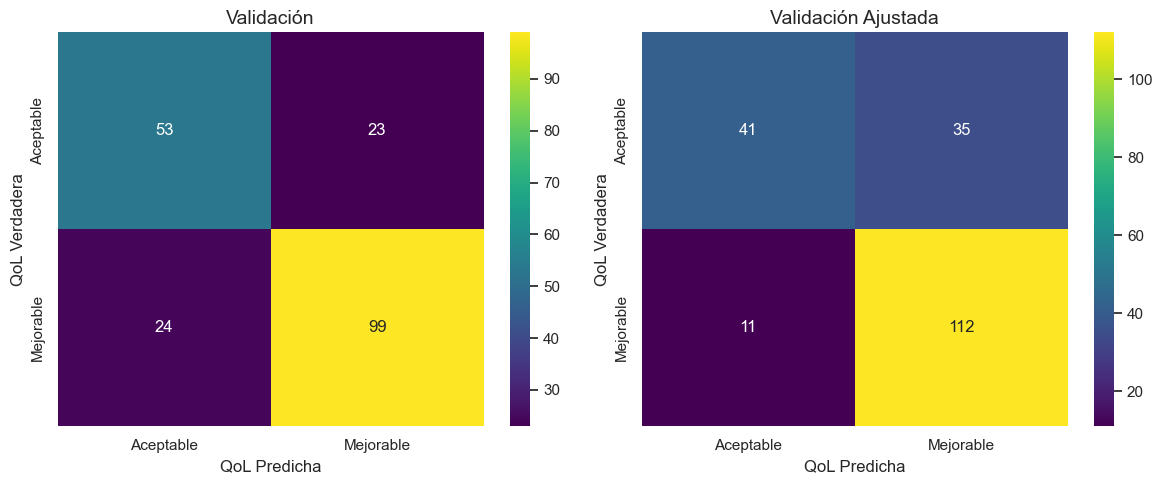

In [27]:
afn.viz_confusion_matrix_thres(labels, y_val, y_pred_val_xg, y_pred_proba_xg)

In [28]:
print(classification_report(y_val, y_pred_proba_xg))

              precision    recall  f1-score   support

         0.0       0.79      0.54      0.64        76
         1.0       0.76      0.91      0.83       123

    accuracy                           0.77       199
   macro avg       0.78      0.73      0.74       199
weighted avg       0.77      0.77      0.76       199



### 2.4 CatBoost

In [29]:
cb_parameters = {
    'depth': [3, 5],
    'learning_rate': [0.06, 0.07],
    'l2_leaf_reg': [3, 4],
    'bagging_temperature': [0, 1],
    'rsm': [0.8, 1.0],
    'border_count': [64, 128],
    'leaf_estimation_iterations': [5, 10]
}

cb_model = CatBoostClassifier(
    loss_function='Logloss', 
    eval_metric='Logloss', 
    random_state=73,
    early_stopping_rounds=50,
    verbose=False
)

cb_grid = GridSearchCV(
    estimator=cb_model,
    param_grid=cb_parameters,
    scoring='f1_macro',
    cv=5,
    n_jobs=-1
)

%time cb_grid.fit(X_train, y_train)

print('Media de F1 score: %.3f' % cb_grid.best_score_)
print('Desviación estándar: ', cb_grid.cv_results_['std_test_score'][cb_grid.best_index_].round(3))
print('Parámetros que producen el clasificador óptimo: ')
print('Profundidad: ', cb_grid.best_params_['depth'])
print('Tasa de aprendizaje: ', cb_grid.best_params_['learning_rate'])
print('Regularización en hojas: ', cb_grid.best_params_['l2_leaf_reg'])
print('Muestreo aleatorio: ', cb_grid.best_params_['bagging_temperature'])
print('Porcentaje de variables utilizado: ', cb_grid.best_params_['rsm'])
print('Número de divisiones: ', cb_grid.best_params_['border_count'])


CPU times: user 1.37 s, sys: 1.27 s, total: 2.63 s
Wall time: 52.6 s
Media de F1 score: 0.768
Desviación estándar:  0.038
Parámetros que producen el clasificador óptimo: 
Profundidad:  3
Tasa de aprendizaje:  0.06
Regularización en hojas:  3
Muestreo aleatorio:  0
Porcentaje de variables utilizado:  0.8
Número de divisiones:  64


In [30]:
cb_model = cb_grid.best_estimator_
cb_model.fit(X_train, y_train)
y_pred_cb = cb_model.predict_proba(X_val)

Reporte sobre el conjunto de ENTRENAMIENTO:
              precision    recall  f1-score   support

         0.0       0.89      0.94      0.91       354
         1.0       0.96      0.93      0.94       574

    accuracy                           0.93       928
   macro avg       0.92      0.93      0.93       928
weighted avg       0.93      0.93      0.93       928

Reporte sobre el conjunto de validation:  VALIDATION
              precision    recall  f1-score   support

         0.0       0.74      0.64      0.69        76
         1.0       0.80      0.86      0.83       123

    accuracy                           0.78       199
   macro avg       0.77      0.75      0.76       199
weighted avg       0.78      0.78      0.78       199



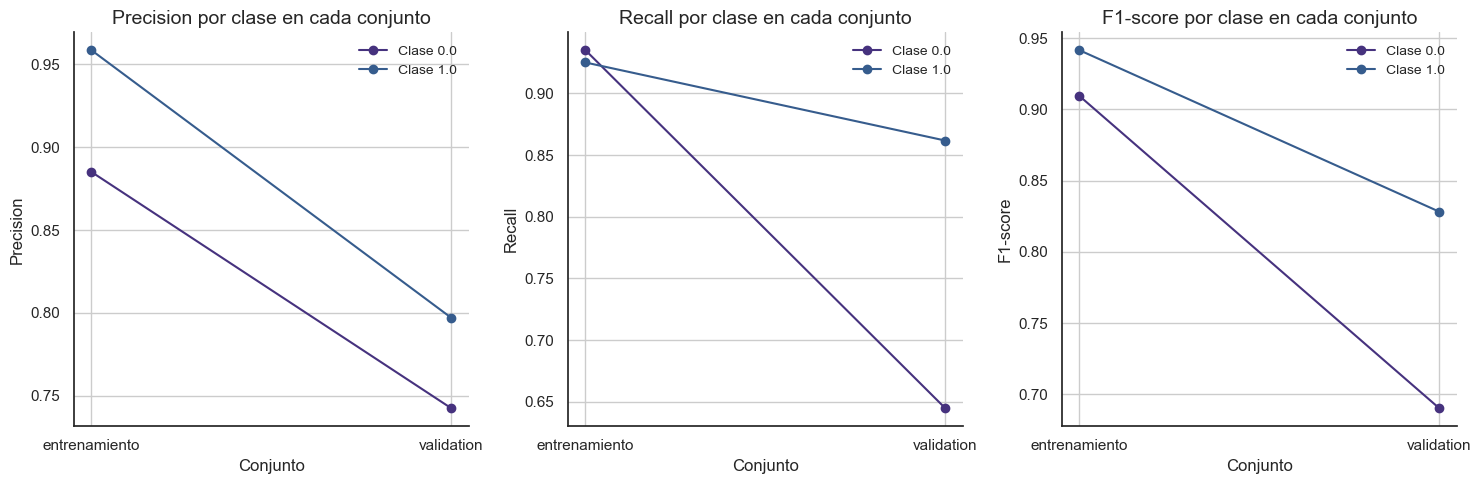

In [31]:
y_pred_train_cb, y_pred_val_cb = afn.viz_classification_reports(cb_model, X_train, y_train, X_val, y_val)

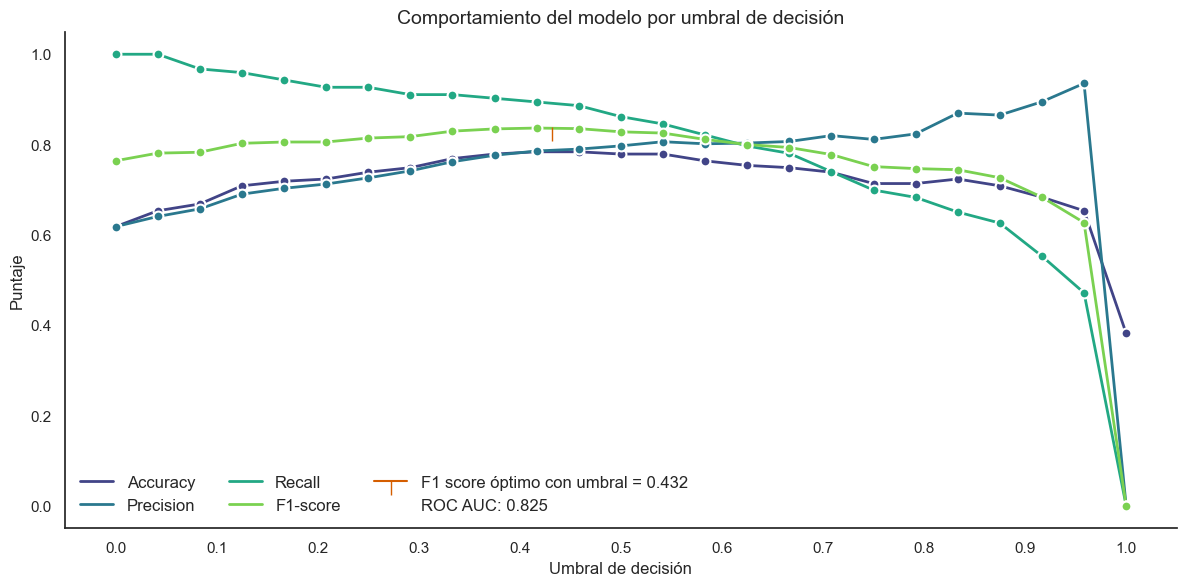

In [32]:
cb_best_threshold, cb_metrics = afn.viz_threshold_behavior(cb_model, X_val, y_val, num_thresholds=25)
cb_metrics['model'] = 'CatBoost'

In [33]:
probs_cb = y_pred_cb[:, 1]
y_pred_proba_cb = (probs_cb >= cb_best_threshold)

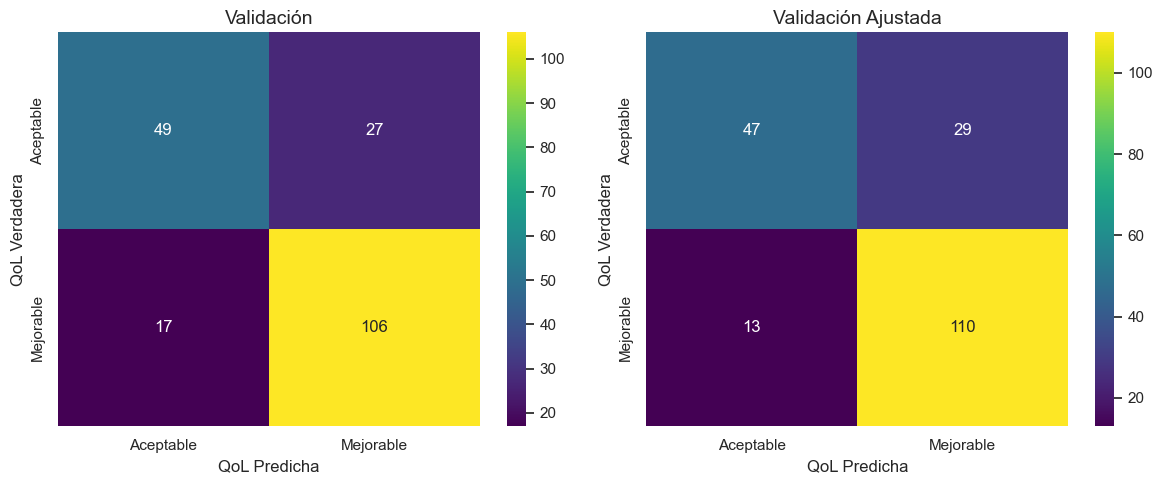

In [34]:
afn.viz_confusion_matrix_thres(labels, y_val, y_pred_val_cb, y_pred_proba_cb)

In [35]:
print(classification_report(y_val, y_pred_proba_cb))

              precision    recall  f1-score   support

         0.0       0.78      0.62      0.69        76
         1.0       0.79      0.89      0.84       123

    accuracy                           0.79       199
   macro avg       0.79      0.76      0.77       199
weighted avg       0.79      0.79      0.78       199



### 2.5 Light Gradient-Boosting Machine (LigthGBM)

In [36]:
lg_parameters = {
    'n_estimators': [130],          #130
    'learning_rate': [0.05],        #0.06
    'max_depth': [6],               #6
    'num_leaves': [9],              #9
    'min_child_samples': [6],       #6
    'reg_alpha': [0.11],            #0.11      
    'reg_lambda': [0.009],          #0.009                 
    'min_split_gain': [0.09],       #0.09            
    'max_bin': [10]                 #10
}

lg_model = LGBMClassifier(
    objective='binary', 
    boosting_type='gbdt', 
    random_state=73, 
    verbose=0,
)

lg_grid = GridSearchCV(
    estimator=lg_model, 
    param_grid=lg_parameters, 
    scoring='f1_macro', 
    cv=5,
    n_jobs=-1,
)
X_train.columns = X_train.columns.str.replace(' ', '_')
X_test.columns = X_test.columns.str.replace(' ', '_')
X_val.columns = X_val.columns.str.replace(' ', '_')
%time lg_grid.fit(X_train, y_train)

print('Media de F1 score: %.3f' % lg_grid.best_score_)
print('Desviación estándar: ', lg_grid.cv_results_['std_test_score'][lg_grid.best_index_].round(3))
print('Parámetros que producen el clasificador óptimo: ')
print('Mínimo de árboles', lg_grid.best_params_['n_estimators'])
print('Profundidad: ', lg_grid.best_params_['max_depth'])
print('Tasa de aprendizaje: ', lg_grid.best_params_['learning_rate'])
print('Número de leaves: ', lg_grid.best_params_['num_leaves'])
print('Mínimo de muestras', lg_grid.best_params_['min_child_samples'])
print('Alpha', lg_grid.best_params_['reg_alpha'])
print('Lambda', lg_grid.best_params_['reg_lambda'])
print('Mínimo de ganancia', lg_grid.best_params_['min_split_gain'])
print('Máximo de bin', lg_grid.best_params_['max_bin'])

CPU times: user 479 ms, sys: 296 ms, total: 775 ms
Wall time: 1.91 s
Media de F1 score: 0.757
Desviación estándar:  0.028
Parámetros que producen el clasificador óptimo: 
Mínimo de árboles 130
Profundidad:  6
Tasa de aprendizaje:  0.05
Número de leaves:  9
Mínimo de muestras 6
Alpha 0.11
Lambda 0.009
Mínimo de ganancia 0.09
Máximo de bin 10


In [37]:
lg_model = lg_grid.best_estimator_
lg_model.fit(X_train, y_train)
y_pred_lg = lg_model.predict_proba(X_val)

Reporte sobre el conjunto de ENTRENAMIENTO:
              precision    recall  f1-score   support

         0.0       0.82      0.86      0.84       354
         1.0       0.91      0.89      0.90       574

    accuracy                           0.88       928
   macro avg       0.87      0.88      0.87       928
weighted avg       0.88      0.88      0.88       928

Reporte sobre el conjunto de validation:  VALIDATION
              precision    recall  f1-score   support

         0.0       0.71      0.70      0.70        76
         1.0       0.81      0.82      0.82       123

    accuracy                           0.77       199
   macro avg       0.76      0.76      0.76       199
weighted avg       0.77      0.77      0.77       199



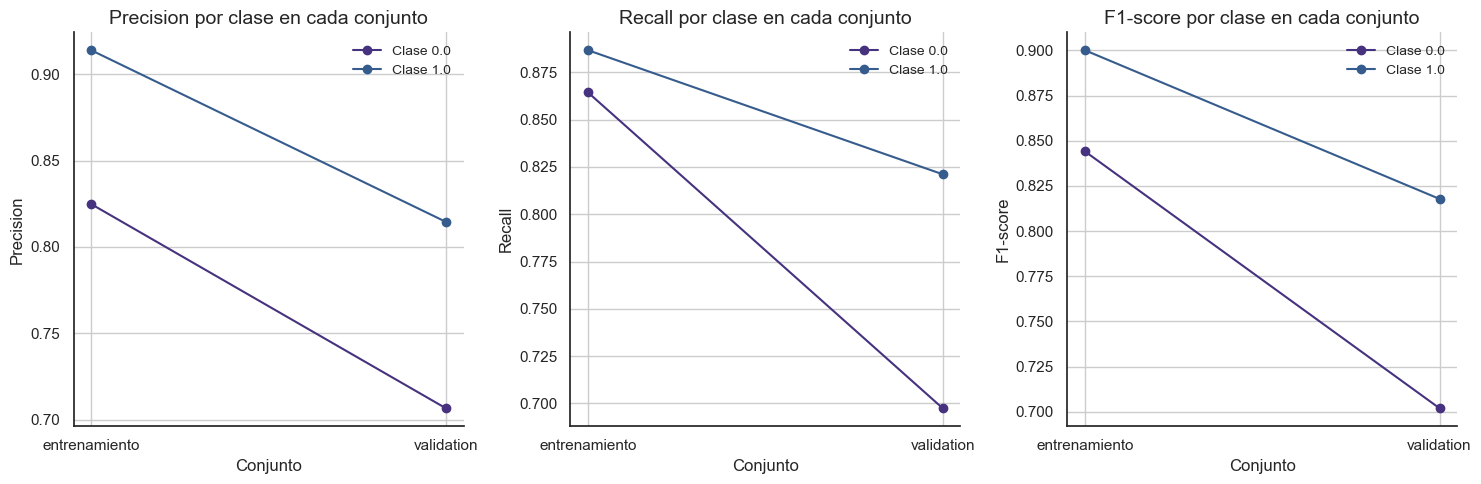

In [38]:
y_pred_train_lg, y_pred_val_lg = afn.viz_classification_reports(lg_model, X_train, y_train, X_val, y_val)

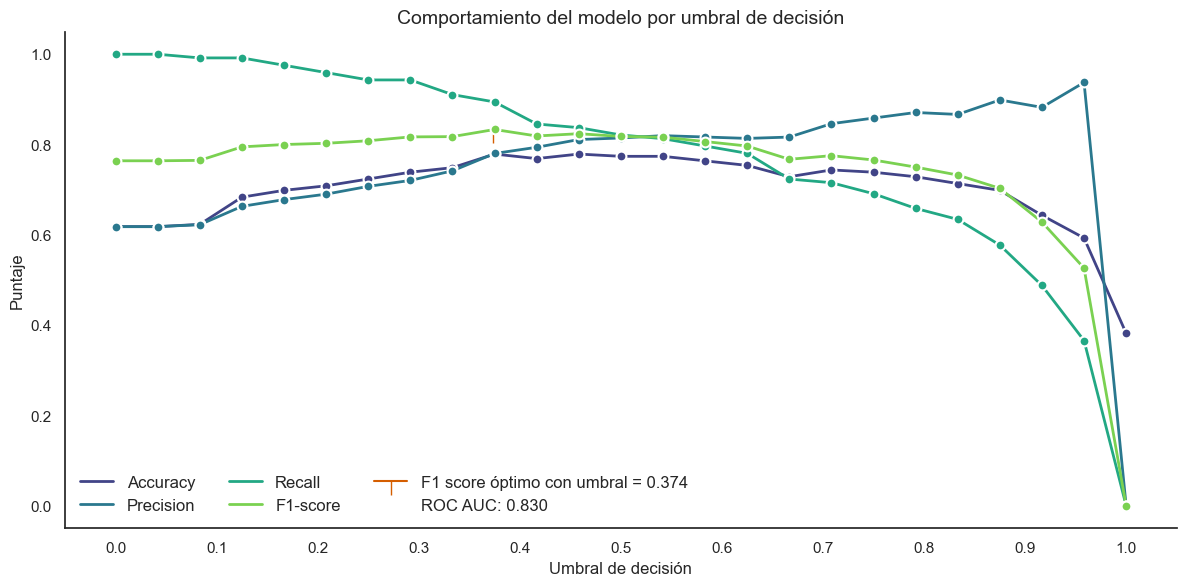

In [39]:
lg_best_threshold, lg_metrics = afn.viz_threshold_behavior(lg_model, X_val, y_val, num_thresholds=25)
lg_metrics['model'] = 'LGB Machine'

In [40]:
probs_lg = y_pred_lg[:, 1]
y_pred_proba_lg = (probs_lg >= lg_best_threshold)

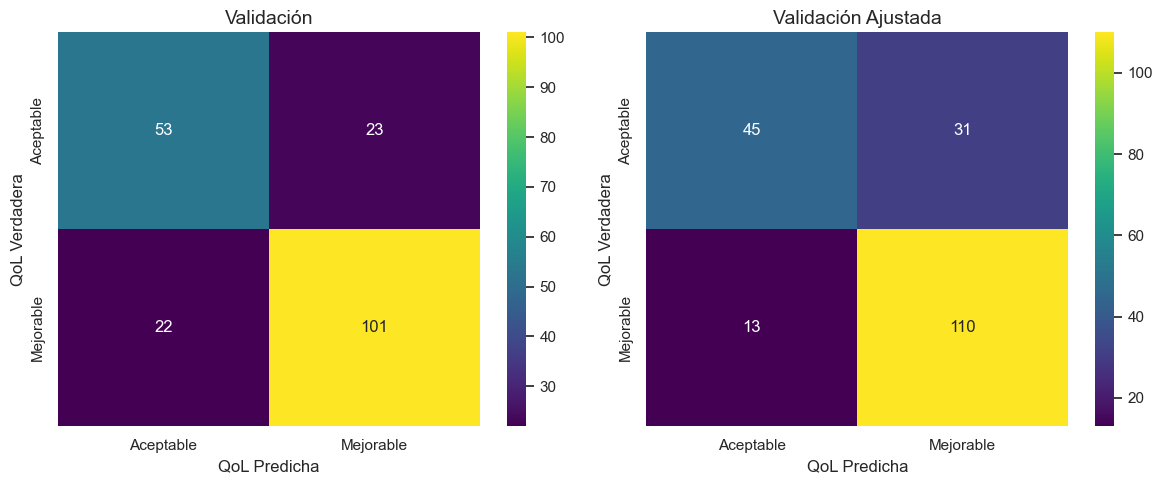

In [41]:
afn.viz_confusion_matrix_thres(labels, y_val, y_pred_val_lg, y_pred_proba_lg)

In [42]:
print(classification_report(y_val, y_pred_proba_lg))

              precision    recall  f1-score   support

         0.0       0.78      0.59      0.67        76
         1.0       0.78      0.89      0.83       123

    accuracy                           0.78       199
   macro avg       0.78      0.74      0.75       199
weighted avg       0.78      0.78      0.77       199



In [43]:
X_train.columns = X_train.columns.str.replace('_', ' ')
X_test.columns = X_test.columns.str.replace('_', ' ')
X_val.columns = X_val.columns.str.replace('_', ' ')

### Selección del modelo


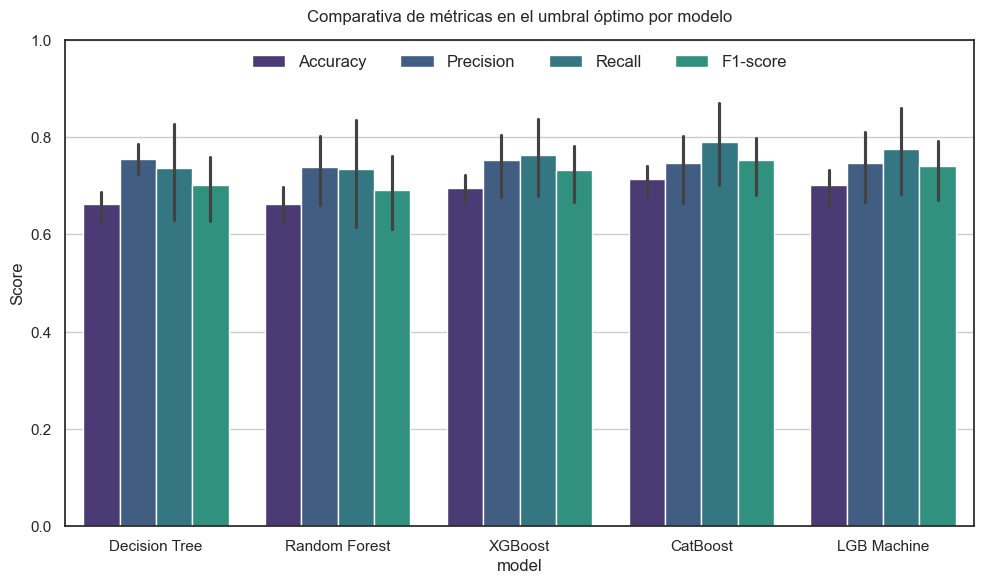

In [44]:
all_metrics = pd.concat([dt_metrics, rf_metrics, xg_metrics, cb_metrics, lg_metrics], ignore_index=True)
melted = all_metrics.melt(id_vars='model', value_vars=['Accuracy', 'Precision', 'Recall', 'F1-score'], var_name='Metric', value_name='Score')

plt.figure(figsize=(10, 6))
sns.barplot(data=melted, x='model', y='Score', hue='Metric')
plt.title('Comparativa de métricas en el umbral óptimo por modelo', y=1.02)
plt.legend(loc='upper center', bbox_to_anchor=(0.5, 1), ncol=4, fontsize=12)
plt.ylim(0, 1)
plt.grid(True, axis='y')
plt.tight_layout()
plt.show()

Reporte sobre el conjunto de ENTRENAMIENTO:
              precision    recall  f1-score   support

         0.0       0.89      0.94      0.91       354
         1.0       0.96      0.93      0.94       574

    accuracy                           0.93       928
   macro avg       0.92      0.93      0.93       928
weighted avg       0.93      0.93      0.93       928

Reporte sobre el conjunto de validation:  VALIDATION
              precision    recall  f1-score   support

         0.0       0.71      0.70      0.70        56
         1.0       0.82      0.83      0.82        92

    accuracy                           0.78       148
   macro avg       0.76      0.76      0.76       148
weighted avg       0.78      0.78      0.78       148



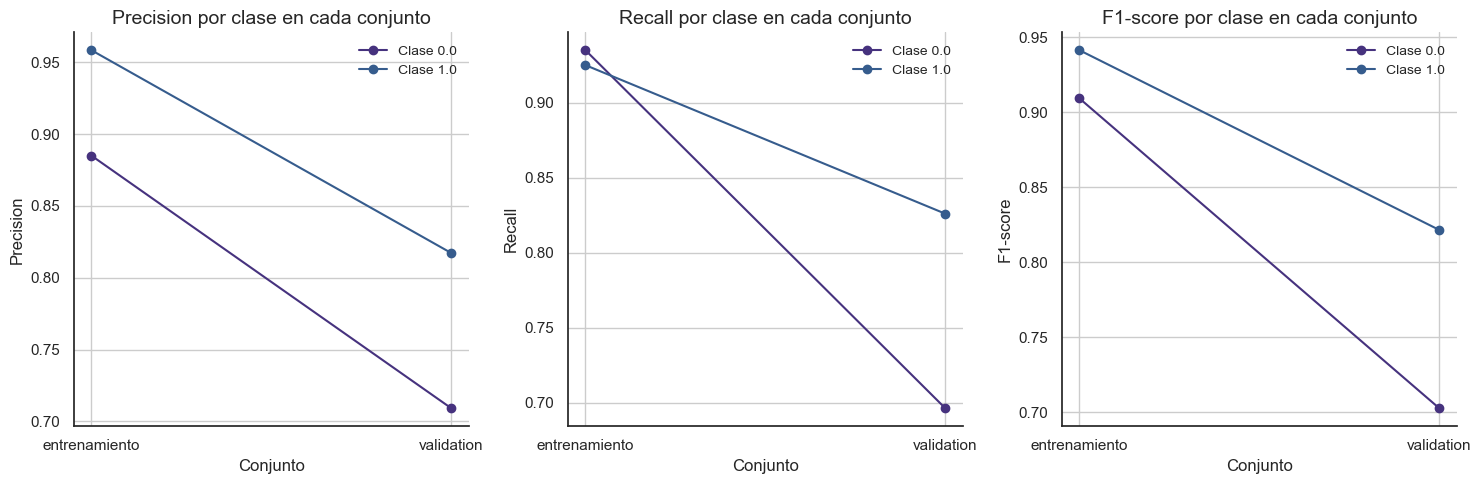

In [45]:
best_model = CatBoostClassifier(
    loss_function='Logloss',
    eval_metric='Logloss',
    random_state=73,
    early_stopping_rounds=50,
    verbose=False,
    # Best params
    depth=3,
    learning_rate=0.06,
    l2_leaf_reg=3,
    bagging_temperature=0,
    rsm=0.8,
    border_count=64,
    leaf_estimation_iterations=5
)

best_model.fit(X_train, y_train)
y_pred_train, y_pred_test = afn.viz_classification_reports(best_model, X_train, y_train, X_test, y_test)

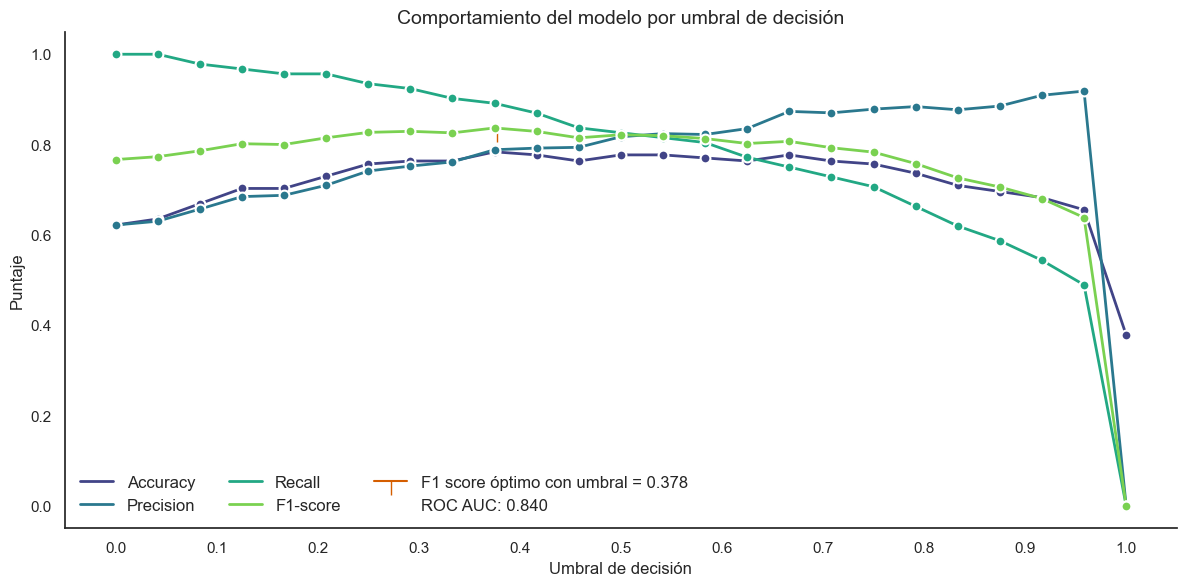

In [46]:
best_threshold, best_metrics = afn.viz_threshold_behavior(best_model, X_test, y_test, num_thresholds=25)

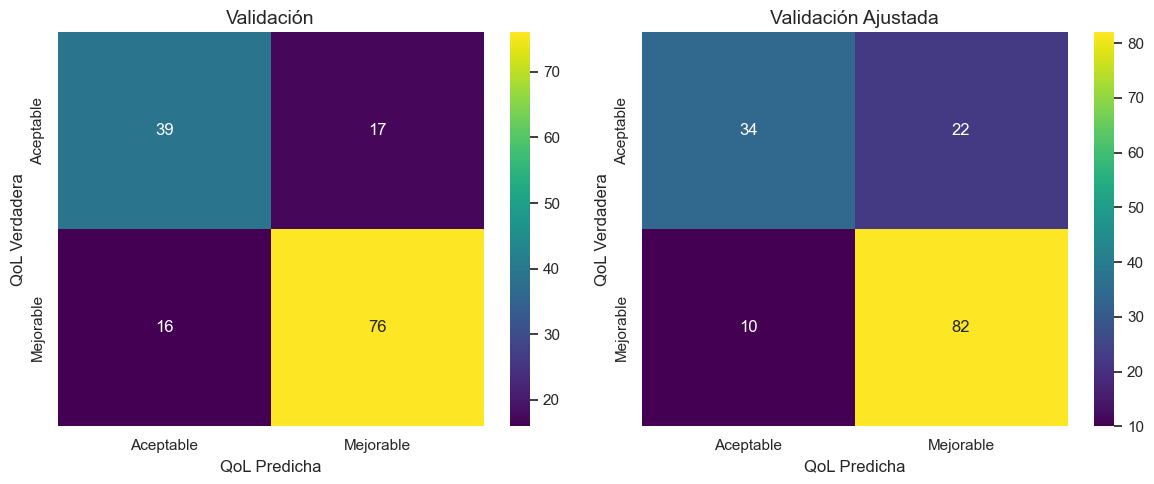

In [47]:
probs = best_model.predict_proba(X_test)[:, 1]
y_pred_proba = (probs >= best_threshold)
afn.viz_confusion_matrix_thres(labels, y_test, y_pred_test, y_pred_proba)


In [48]:
print(classification_report(y_val, y_pred_proba_lg))

              precision    recall  f1-score   support

         0.0       0.78      0.59      0.67        76
         1.0       0.78      0.89      0.83       123

    accuracy                           0.78       199
   macro avg       0.78      0.74      0.75       199
weighted avg       0.78      0.78      0.77       199



## Exportación del modelo seleccionado y los datos


In [49]:
bundle = {
    'model': cb_model,
    'threshold': best_threshold
}
joblib.dump(bundle, './models/CatBoost_bundle.pkl')

['./models/CatBoost_bundle.pkl']

In [50]:
X_cal.to_csv('./data/QLQ_C30_C23_X_cal.csv', index=False)
y_cal.to_csv('./data/QLQ_C30_C23_y_cal.csv', index=False)
X_train.to_csv('./data/QLQ_C30_C23_X_train.csv', index=False)
X_test.to_csv('./data/QLQ_C30_C23_X_test.csv', index=False)
y_train.to_csv('./data/QLQ_C30_C23_y_train.csv', index=False)
y_test.to_csv('./data/QLQ_C30_C23_y_test.csv', index=False)